# ANA 680 Midterm - Predicting Student Race by Performance
# Leticia Genao

##### Dataset source: (https://www.kaggle.com/datasets/spscientist/students-performance-in-exams/data). 
#### Purely for educational purposes of the class ANA680.


In [49]:
#Import  libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import cross_val_score
import pickle

In [50]:
# Loading the dataset
file_path = 'data/StudentsPerformance.csv'
df=pd.read_csv(file_path)

# **Data Exploration**

In [51]:
# Show all the data
print("Basic DataFrame information:")
print(df.info())
print(df)

# Show the first five rows of the DataFrame
df.head()

Basic DataFrame information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB
None
     gender race/ethnicity parental level of education         lunch  \
0    female        group B           bachelor's degree      standard   
1    female        group C                some college      standard   
2    female        group

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [52]:
# Show Summary statistics for the DataFrame
df.describe()

,math score,reading score,writing score
count,1000.00000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000
std,15.16308,14.600192,15.195657
min,0.00000,17.000000,10.000000
25%,57.00000,59.000000,57.750000
50%,66.00000,70.000000,69.000000
75%,77.00000,79.000000,79.000000
max,100.00000,100.000000,100.000000


## Observations
- The 0 in math might indicate either an absence or extremely poor performance
- Median (50%) The fact that these medians are so near to the means indicates that the data are distributed symmetrically about the center.
- With the exception of the minimum scores, which may call for additional research to determine if they are the result of incorrect data entry, test absences, or real scores, the score distributions show a usual spread with no extreme anomalies.

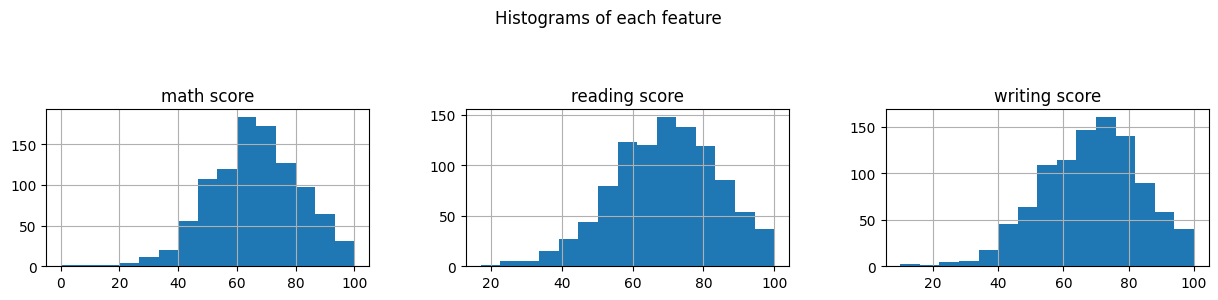

In [53]:
# Histograms for each feature
df.hist(bins=15, figsize=(15, 10), layout=(4, 3))
plt.suptitle('Histograms of each feature')
plt.show()

### Observations
The dataset's math, reading, and writing histograms provide distributions that shed light on how well students performed in these areas. The math scores show a little left skew, indicating that some students may find this subject difficult. The majority of the scores fall between 60 and 80. The distribution of reading scores is more symmetrical and resembles a normal distribution, suggesting that students' skill levels are more consistent. The pattern of writing scores is similar to that of reading scores, although there is a little bias in favor of higher scores, which may indicate superior performance or more lenient grading in writing than in math. These distributions point to possible areas for focused educational interventions and indicate a range of student competency levels, especially in arithmetic where a significant proportion of kids perform below expectations.

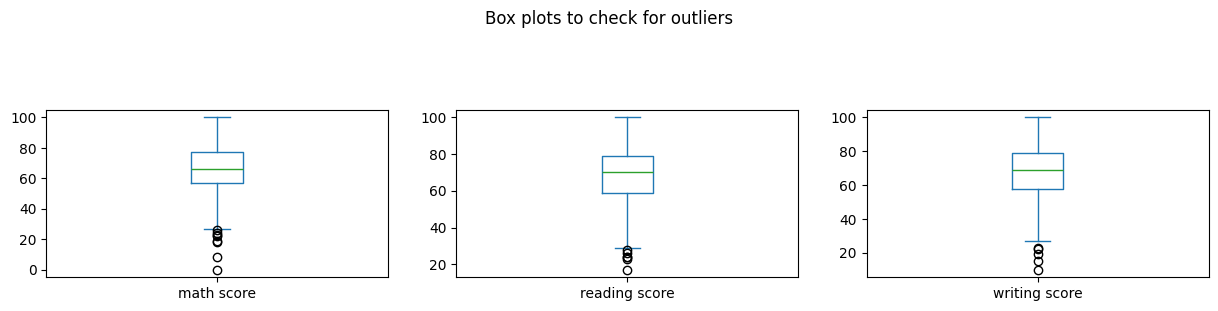

In [54]:

# Box plots to check for outliers
df.plot(kind='box', subplots=True, layout=(4, 3), sharex=False, sharey=False, figsize=(15, 10))
plt.suptitle('Box plots to check for outliers')
plt.show()

### Observations
With medians of roughly 66, 70, and 69 for math, reading, and writing scores, respectively, and interquartile ranges showing most students grouping within a medium performance range, the box plots show a central tendency. Interestingly, there are outliers in all three disciplines, especially at the lower end, suggesting that a portion of pupils perform noticeably worse than their colleagues. The majority of these outliers occur in the areas of reading and arithmetic, indicating that these subjects would benefit from more support or focused educational interventions to help struggling pupils improve. 

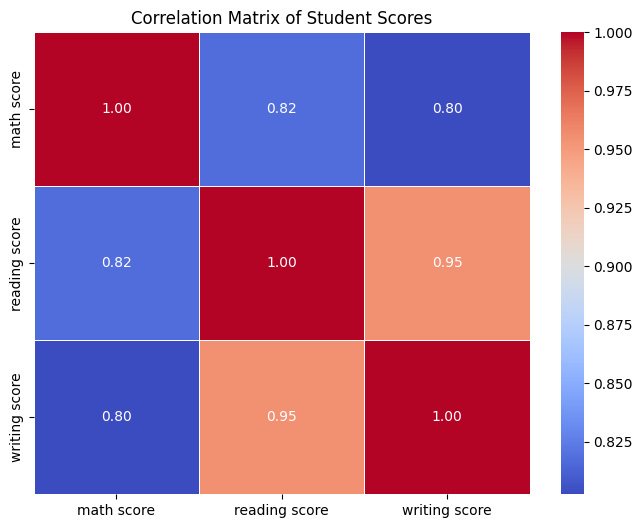

In [55]:
# Calculating the correlation matrix for the score columns
correlation_matrix = df[['math score', 'reading score', 'writing score']].corr()

# Heatmap to visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Student Scores')
plt.show()

### Observations
Strong positive connections can be seen in the correlation matrix of student results in math, reading, and writing, suggesting that children who do well in one area also tend to do well in the others. In particular, the  0.95 correlation between reading and writing indicates a substantial overlap in the skills needed for both subjects. Additionally, there are strong relationships between math and writing (0.82 and 0.80, respectively), suggesting that the ability to solve mathematical problems well may influence or be correlated with language and comprehension skills. These findings support a comprehensive approach to student learning and development by indicating that instructional practices that improve one skill are likely to benefit others as well.

# **Data Cleaning and Preprocessing**

In [56]:
# Convert column names to snake_case for consistency and easier coding
df.columns = [col.strip().replace(' ', '_').lower() for col in df.columns]
print(df.columns)

Index(['gender', 'race/ethnicity', 'parental_level_of_education', 'lunch',
       'test_preparation_course', 'math_score', 'reading_score',
       'writing_score'],
      dtype='object')


In [57]:
df.rename(columns = {'race/ethnicity':'race_ethnicity'}, inplace = True)

In [58]:
print(df.columns)

Index(['gender', 'race_ethnicity', 'parental_level_of_education', 'lunch',
       'test_preparation_course', 'math_score', 'reading_score',
       'writing_score'],
      dtype='object')


In [59]:
# Label encode the target variable 'race_ethnicity'
encoder = LabelEncoder()
df['race_ethnicity'] = encoder.fit_transform(df['race_ethnicity'])

# Building the Model

In [60]:
# Selecting only the relevant features
X = df[['math_score', 'reading_score', 'writing_score']]
y = df['race_ethnicity']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Handling class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Training a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_smote, y_train_smote)

# Predicting on the test set
y_pred = rf_classifier.predict(X_test)

# Calculating and printing the accuracy and other metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.22
[[ 5  5  8  5  2]
 [ 8  8 18  7  7]
 [ 8 18 22 12 16]
 [ 7 16 22 13 14]
 [ 2  4 10  6  7]]
              precision    recall  f1-score   support

           0       0.17      0.20      0.18        25
           1       0.16      0.17      0.16        48
           2       0.28      0.29      0.28        76
           3       0.30      0.18      0.23        72
           4       0.15      0.24      0.19        29

    accuracy                           0.22       250
   macro avg       0.21      0.22      0.21       250
weighted avg       0.24      0.22      0.22       250



In [61]:
# Cross-validating the model due to the low accuracy score
scores = cross_val_score(rf_classifier, X, y, cv=5)
print("Cross-Validation Accuracy Scores:", scores)


Cross-Validation Accuracy Scores: [0.275 0.24  0.26  0.325 0.275]


In [64]:
# Saving the trained model using pickle
pickle.dump(rf_classifier, open('model.pkl', 'wb'))
pickle.dump(encoder, open('encoder.pkl', 'wb'))  # Saving the encoder
